# Example 10.1
Using Picard’s process of successive approximations, obtain a solution 
up to the fifth approximation of the equation dy/dx = y + x, such that 
y = 1 when x = 0. Check your answer by finding the exact particular solution.

Exact Solution upto x^6 = x**6/360 + x**5/60 + x**4/12 + x**3/3 + x**2 + x + 1
Exact Solution at (x=1) = 3.436564

y_0 = 1
y_1 = x**2/2 + x + 1
y_2 = x**3/6 + x**2 + x + 1
y_3 = x**4/24 + x**3/3 + x**2 + x + 1
y_4 = x**5/120 + x**4/12 + x**3/3 + x**2 + x + 1
y_5 = x**6/720 + x**5/60 + x**4/12 + x**3/3 + x**2 + x + 1

y_4(1) = 3.425000
y_5(1) = 3.434722


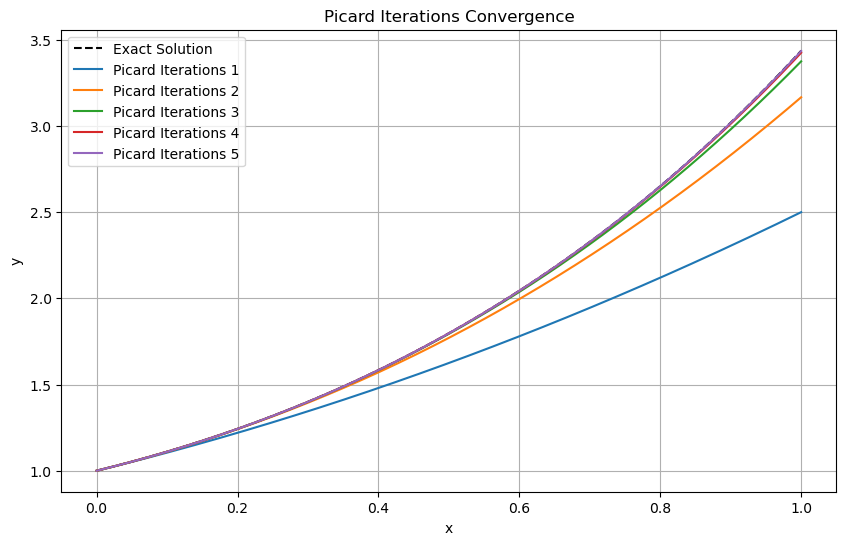

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), x + y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
series_sol = sp.series(sol.rhs, x, 0, 7).removeO()
print('Exact Solution upto x^6 =', series_sol)
print(f'Exact Solution at (x=1) = {sol.rhs.subs(x, 1):.6f}')

def f(x, y):
    return x + y

def picard_method(f, x0, y0, iter):
    y_prev = y0
    iterations = [y0]
    print('\ny_0 =', y0)

    for i in range(1, iter+1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, 0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        print(f'y_{i} = {y_next}')
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 1, 5)
print(f'\ny_4(1) = {picard_iterations[4].subs(x, 1):.6f}')
print(f'y_5(1) = {picard_iterations[5].subs(x, 1):.6f}')

x_vals = np.linspace(0, 1, 200)
exact_func = sp.lambdify(x, sol.rhs, 'numpy')
exact_vals = exact_func(x_vals)


plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, 'k--', label='Exact Solution')

for i in range(1, len(picard_iterations)):
    picard_funcs = sp.lambdify(x, picard_iterations[i], 'numpy')
    picard_vals = picard_funcs(x_vals)
    plt.plot(x_vals, picard_vals, label=f'Picard Iterations {i}')
plt.title('Picard Iterations Convergence')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ===================================
# PINN for Example 10.1
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - y - x_colloc
    loss_pde = torch.mean(f**2)
    
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.tensor([[1.0]], dtype=torch.float32, device=device)
y_pinn = model(x_pinn).detach().cpu().numpy()[0, 0]

print(f'\nPINN Solution at x=1: {y_pinn:.6f}')
print(f'Exact Solution at x=1: {sol.rhs.subs(x, 1):.6f}')

# ===================================
# Enhanced Plot with PINN
# ===================================
x_plot = np.linspace(0, 1, 200)
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.plot(x_vals, exact_vals, 'k--', label='Exact Solution', linewidth=2)

for i in range(1, len(picard_iterations)):
    picard_funcs = sp.lambdify(x, picard_iterations[i], 'numpy')
    picard_vals = picard_funcs(x_vals)
    plt.plot(x_vals, picard_vals, label=f'Picard Iterations {i}', alpha=0.7)

plt.plot(x_plot, y_pinn_plot, 'r-', label='PINN', linewidth=2)
plt.title('Picard Iterations vs Exact vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Example 10.2
Find the value of y for x = 0.1 by Picard’s method, given that dy/dx = (y - x) / y + x , y(0)=1.

In [5]:
import sympy as sp

x = sp.Symbol('x')

def f(x, y):
    return (y - x) / (y + x)

def picard_method(f, x0, y0, n):

    y_prev = y0

    iterations = [y0]

    for i in range(1, n+1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, x0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        print(f'y_{i} = {y_next}\n')
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 1, 2)
print(f'\ny_1(0.1) = {picard_iterations[1].subs(x, 0.1):.6f}')

y_1 = -x + 2*log(x + 1) + 1

y_2 = -Integral(2*x/(2*log(x + 1) + 1), (x, 0, x)) - Integral(-2*log(x + 1)/(2*log(x + 1) + 1), (x, 0, x)) - Integral(-1/(2*log(x + 1) + 1), (x, 0, x)) + 1


y_1(0.1) = 1.090620


# Exercise 10.1
Using Picard’s method, solve dy/dx = – xy with x0 = 0, y0 = 1 up to the third approximation.

Exact Series Solution upto x^8 = -x**10/3840 + x**8/384 - x**6/48 + x**4/8 - x**2/2 + 1
Exact Solution at (x=1) = 0.606531

y_0 = 1
y_1 = 1 - x**2/2
y_2 = x**4/8 - x**2/2 + 1
y_3 = -x**6/48 + x**4/8 - x**2/2 + 1
y_4 = x**8/384 - x**6/48 + x**4/8 - x**2/2 + 1
y_5 = -x**10/3840 + x**8/384 - x**6/48 + x**4/8 - x**2/2 + 1

y_1(1) = 0.500000

y_2(1) = 0.625000

y_3(1) = 0.604167

y_4(1) = 0.606771

y_5(1) = 0.606510


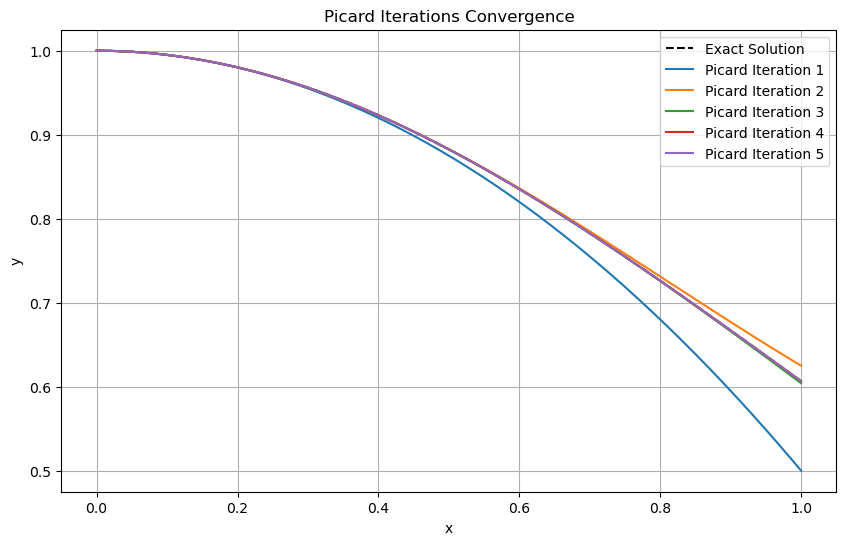

In [34]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), -x*y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
series_sol = sp.series(sol.rhs, x, 0, 12).removeO()
print('Exact Series Solution upto x^8 =', series_sol)
print(f'Exact Solution at (x=1) = {sol.rhs.subs(x, 1):.6f}')

def f(x, y):
    return -x * y

def picard_method(f, x0, y0, n):

    y_prev = y0
    print('\ny_0 =', y_prev)
    iterations = [y0]

    for i in range(1, n + 1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, x0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        print(f'y_{i} = {y_next}')
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 1, 5)
for i in range(1, len(picard_iterations)):
    print(f'\ny_{i}(1) = {picard_iterations[i].subs(x, 1):.6f}')

x_vals = np.linspace(0, 1, 200)
exact_func = sp.lambdify(x, sol.rhs,'numpy')
exact_vals = exact_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, 'k--', label='Exact Solution')

for i in range(1, len(picard_iterations)):
    picard_funcs = sp.lambdify(x, picard_iterations[i], 'numpy')
    picard_vals = picard_funcs(x_vals)
    plt.plot(x_vals, picard_vals, label=f'Picard Iteration {i}')

plt.title('Picard Iterations Convergence')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.2

In [41]:
import sympy as sp

x = sp.Symbol('x')

def f(x, y):
    return x**2 + y**2

def picard_method(f, x0, y0, iter):

    y_prev = y0
    iterations = [y0]
    print('y_0 =', y_prev)

    for i in range(1, iter+1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, x0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 0, 5)
for i in range(1, len(picard_iterations)):
    print(f'y_{i}(0.4) = {picard_iterations[i].subs(x, 0.4):.4f}')

y_0 = 0
y_1(0.4) = 0.0213
y_2(0.4) = 0.0214
y_3(0.4) = 0.0214
y_4(0.4) = 0.0214
y_5(0.4) = 0.0214


# Exercise 10.3

In [48]:
import sympy as sp

x = sp.Symbol('x')

def f(x, y):
    return x**2 / (y**2 + 1)

def picard_method(f, x0, y0, iter):

    y_prev = y0

    iterations = [y0]

    for i in range(1, iter+1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, x0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 0, 2)
for i in range(1, len(picard_iterations)):
    print(f'y_{i} = {sp.series(picard_iterations[i], x, 0, 12).removeO()}')

y_1 = x**3/3
y_2 = -x**9/81 + x**3/3


# Example 10.4

In [61]:
import sympy as sp

x = sp.Symbol('x')

# Picard Method

def f(x, y):
    return x - y**2

def picard_method(f, x0, y0, iter):

    y_prev = y0
    iterations = [y0]

    for i in range(1, iter+1):
        integrand = f(x, y_prev)
        integral = sp.integrate(integrand, (x, x0, x))
        y_next = y0 + integral
        iterations.append(y_next)
        y_prev = y_next
    return iterations
picard_iterations = picard_method(f, 0, 1, 3)
for i in range(1, len(picard_iterations)):
    print(f'Picard Iteration y_{i}(0.1) = {picard_iterations[i].subs(x, 0.1):.6f}')

# Taylor Series

def taylor_series(f1, x0, y0, N):
    der =[y0]
    y1 = f1.subs({x: x0, y: y0})
    der.append(y1)

    current = f1
    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]
        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)
    return T, der
y = sp.Function('x')(x)
f1 = x - y**2
T, der = taylor_series(f1, 0, 1, 4)
print(f'\nTaylor Series = {T.subs(x, 0.1):.6f}')

Picard Iteration y_1(0.1) = 0.905000
Picard Iteration y_2(0.1) = 0.914358
Picard Iteration y_3(0.1) = 0.913767

Taylor Series = 0.913667


# Exercise 10.5